# Basic example
In this tutorial, it will be shown how to create data set from any source of data. It will also be shown how to create PDF object from a given set of parameters, and how to generate sample from it and fit it accordingly. Before doing any operation with the minkit package, it is recommended to impot it an call the "initialize" function. This will define the backend where the operations will be done (CPU, CUDA or OpenCL). By default it runs on CPU.


In [1]:
%matplotlib inline
import minkit
minkit.initialize()

## Creating a data set
Data sets can be constructed in many different manners. In this tutorial we will work in the 1-D case, which is also the most common situation. First we need to define the parameter associated to the data. In our case, it will be considered to have values between -5 and +5.
These bounds will define the valid range for the different operations of the PDF involving it. The data set can be easily constructed using calling

In [2]:
import numpy as np
x = minkit.Parameter('x', bounds=(-5, +5))
raw = np.random.normal(0, 1, 10000)
real_data = minkit.DataSet.from_array(raw, x)

Now the data set contains values following a Gaussian distribution between -5 and +5.

## Creating a PDF
Creating a PDF needs to define previously a set of parameters that rule the behaviour of the function. Let's take a closer look to our data parameter.

In [3]:
print(x)

Parameter(name=x, value=None, bounds=[-5.  5.], error=0.0, constant=False)


As you can see, the created parameter has information about the name, value, bounds, its error, and whether it must be considered as constant (something important when doing fits).
We will now create a Gaussian function. A Gaussian function also needs a parameter corresponding to the center, and another for the standard deviation.

In [4]:
c = minkit.Parameter('c', value=0.)
s = minkit.Parameter('s', value=1.)

The PDF is constructed taking these parameters as input arguments, together with a name, that identifies the new PDF object.

In [5]:
g = minkit.Gaussian('g', x, c, s)

## Generating data
Let's now create some data, which can be easily done using the "generate" method of the newly created PDF.

In [6]:
data = g.generate(10000)

This creates a new data set, that in this case only has one associated data parameter. It is easy to plot the output since we can access the data for each data parameter as a dictionary.

In [7]:
data['x']

array([-1.90314868,  2.0881162 ,  0.10571519, ...,  1.59224807,
        0.4181289 , -0.09362192])

It is important to note that if we are working on a backend involving GPUs, then it is necessary to copy the contents to the CPU before working with numpy or matplotlib. This can be done with the "as_ndarray" function, and is a good practice to use it wherever we work with exclusively CPU operations, since changing from one backend to the other will become trivial. In this case, the returned object will be the same as in the previous operation.


In [8]:
minkit.as_ndarray(data['x'])

array([-1.90314868,  2.0881162 ,  0.10571519, ...,  1.59224807,
        0.4181289 , -0.09362192])

## Plotting the results
In order to overlay the PDF, it must be renormalized. This is done with "scale_pdf_values", in such a way that we can define as many points as we want to evaluate the PDF, since the PDF will always appear normalized.

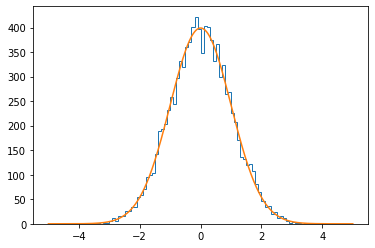

In [9]:
import matplotlib.pyplot as plt
values, edges, _ = plt.hist(minkit.as_ndarray(data['x']), bins=100, range=x.bounds, histtype='step') # Plot the data
grid = minkit.evaluation_grid(data.data_pars, x.bounds, 1000) # Evaluate the PDF in these bins
sf = minkit.scale_pdf_values(g, grid, values, edges) # Scale the values of the PDF
plt.plot(minkit.as_ndarray(grid['x']), minkit.as_ndarray(sf)); # Plot the PDF

## Running a simple fit
Let's now fit the data. The process of generating a sample following a distribution from a PDF and fitting it afterwards to the same function is very common in order to test for fit estability. In order to do this, first we must initialize a minimizer. These are declared within a context, since some machinery is activated behind your back in order to enable caches for constant PDFs or interpolation maps. It is very important that we do not modify the values of our PDF within this context, since it may lead to undefined behaviour.

In [10]:
c.bounds = (-1, +1)
s.bounds = (0.1, 5)
with minkit.minimizer('uml', g, data, minimizer='minuit') as minimizer:
    # Now "g" must not be modified
    r = minimizer.migrad()
    print(r)

------------------------------------------------------------------
| FCN = 2.851E+04               |      Ncalls=44 (44 total)      |
| EDM = 2.03E-09 (Goal: 1E-05)  |            up = 1.0            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   True    |   True    | False  |
------------------------------------------------------------------
------------------------------------------------------------------------------------------
|   | Name |   Value   | Hesse Err | Minos Err- | Minos Err+ | Limit-  | Limit+  | Fixed |
--------------

The first argument to "minimizer" is the FCN type, which defines the figure of merit to minimize. The second is the PDF and the third is the data set. For this case, the Minuit minimizer is used, so "minimizer" becomes the "Minuit" class from the iminuit package. We can extract the values of the parameters by calling

In [11]:
reg = minkit.minuit_to_registry(r.params)
print(reg)

[Parameter(name=c, value=-0.0019128253895673852, bounds=[-1.  1.], error=0.010042812492759179, constant=False), Parameter(name=s, value=1.0063415148412655, bounds=[0.1 5. ], error=0.007116683650607414, constant=False)]


This object will allow us to treat the information from new Parameter objects.